## Извлечение данных

In [2]:
import re
import pandas as pd
from datetime import datetime
import eval7, pprint
from poker.room.pokerstars import PokerStarsHandHistory
from poker.hand import Hand, Combo
import numpy as np
from phevaluator import evaluate_cards

In [121]:
# Создали словарь
data_pd = {'TypeOfRoom': [], 'HandId': [], 'Tournament': [], 'Level': [], 'Date': [], 'Hour': [],
           'TimeZoneAbb': [], 'Table': [], 'NoOfPlayers': [], 'bain': [], 'HandHiro': [], 'Board': []}

# Открываем файл
with open('Poker_\SNG dimetruk 1-54133.txt', 'r') as f:
    data = f.read()
    
# Ищем нужные данные
result = re.findall('(\w+) Hand #(\d*): Tournament #(\d*),(.*) Level (.*) - (\d{4}/\d+/\d+) (\d+\D\d+\D\d+) (\w*)', data)
Tables = re.findall('Table \'.*\' (.*) Seat .*\n', data)
bains = re.findall('(\D\d+\.\d+\+\D\d+\.\d+)', data)
HandHiros = re.findall("Dealt to dimetruk \D(.. ..)\D", data)
Boards = re.findall("Board \[(.*)\]", data)


# Считаем сколко фишек
s = re.findall('Seat (\d).*chips', data)
s = [int(x) for x in s]
seats = []
length = 1
for i in range(len(s)-1):
    if s[i+1] < s[i]:
        seats.append(length)
        length = 1
    else:
        length += 1
seats.append(length)


# ЗАполнЯем словарь данными
for r, table, bain, seat, handHiro, board in zip(result, Tables, bains, seats, HandHiros, Boards):
    data_pd['TypeOfRoom'].append(r[0])
    data_pd['HandId'].append(r[1])
    data_pd['Tournament'].append(r[2])
    # data_pd['info'].append(r[3])
    data_pd['Level'].append(r[4])
    data_pd['Date'].append(r[5])
    data_pd['Hour'].append(r[6])
    data_pd['TimeZoneAbb'].append(r[7])
    data_pd['Table'].append(table) #table
    data_pd['NoOfPlayers'].append(seat)
    data_pd['bain'].append(bain)
    data_pd['HandHiro'].append(handHiro)
    data_pd['Board'].append(board)

# Создаём ДатаФрейм
df = pd.DataFrame(data_pd)
df.head()

,TypeOfRoom,HandId,Tournament,Level,Date,Hour,TimeZoneAbb,Table,NoOfPlayers,bain,HandHiro,Board
0,PokerStars,189303406555,2369603774,IV (40/80),2018/07/30,0:01:30,MSK,9-max,6,$13.70+$1.30,Qh 6h,8h 7d 2h 8c 4s
1,PokerStars,189303615886,2369603774,V (60/120),2018/07/30,0:05:40,MSK,9-max,6,$13.70+$1.30,Qc Td,Qh 5h Js Kd
2,PokerStars,189303670340,2369603774,V (60/120),2018/07/30,0:06:42,MSK,9-max,6,$13.70+$1.30,Ac 7d,2d Ad Ah Js 6s
3,PokerStars,189303726585,2369603774,V (60/120),2018/07/30,0:07:47,MSK,9-max,6,$13.70+$1.30,Tc Qc,Td 5h 2c 5d Kd
4,PokerStars,189303781865,2369603774,V (60/120),2018/07/30,0:08:51,MSK,9-max,6,$13.70+$1.30,Qs 5d,9s 7h Jh 8h 9d


## Преобразуем строковые данные

In [122]:
date = data_pd['Date']
time = data_pd['Hour']

df["Date"] = pd.to_datetime(data_pd['Date'])
df["Time"] = pd.to_timedelta(data_pd['Hour'])

df["DateTime"] = df["Date"] + df["Time"]
df["DateTime"]

df.Tournament = df.Tournament.astype('int64')
df = df.astype({'HandId': np.int64, 'Tournament': np.int64})

In [123]:
# объеденяем руку и борд, выводим название комбинации

df['hand'] = df['HandHiro'] + " " + df['Board']
# hand = df['hand'].values[7].split()
# print(hand)

hand_ev = [eval7.Card(s) for s in (df['hand'].values[7].split())]
rang = eval7.evaluate(hand_ev)   # ранг комбинации
# print(rang)

eval7s = eval7.handtype(rang)  #  название комбинации

df['rang'] = eval7.evaluate(hand_ev)
df['eval7s'] =  eval7.handtype(rang)

In [124]:
df[['DateTime','hand', 'rang', 'eval7s']].head()  # применим фильтер по столбцам

,DateTime,hand,rang,eval7s
0,2018-07-30 00:01:30,Qh 6h 8h 7d 2h 8c 4s,17484656,Pair
1,2018-07-30 00:05:40,Qc Td Qh 5h Js Kd,17484656,Pair
2,2018-07-30 00:06:42,Ac 7d 2d Ad Ah Js 6s,17484656,Pair
3,2018-07-30 00:07:47,Tc Qc Td 5h 2c 5d Kd,17484656,Pair
4,2018-07-30 00:08:51,Qs 5d 9s 7h Jh 8h 9d,17484656,Pair


In [125]:
# def new_type(row):
#     if row.traffic_source.lower() in ('yandex', 'google'):
#         return 'organic'
#     elif row.traffic_source.lower() in ('paid', 'email'):
#         if row.region.lower() == 'russia':
#             return 'ad'
#         else:
#             return 'other'

In [126]:
# log['source_type'] = log.apply(new_type, axis = 1)
# log.head(12)

In [127]:
# log.loc[log.traffic_source.isin(['yandex', 'google']), 'traffic_type'] = 'organic' 

In [128]:
df['hand_rang'] = df['HandHiro'] + " " + df['Board']
df['hand_rang']

print(type(df['hand_rang']), type(df['hand_rang'].values[7].split()))
df['hand_rang'].values[0].split()

<class 'pandas.core.series.Series'> <class 'list'>


['Qh', '6h', '8h', '7d', '2h', '8c', '4s']

In [129]:
# df['hand_rang'].to_list()
# df['hand_rang'].tolist()
# np.array(df['hand_rang'].tolist())
# Ls = list(df['hand_rang'])
ls = df['hand_rang'].str.split()
ls

0        [Qh, 6h, 8h, 7d, 2h, 8c, 4s]
1            [Qc, Td, Qh, 5h, Js, Kd]
2        [Ac, 7d, 2d, Ad, Ah, Js, 6s]
3        [Tc, Qc, Td, 5h, 2c, 5d, Kd]
4        [Qs, 5d, 9s, 7h, Jh, 8h, 9d]
                     ...             
54128    [3c, 7s, 5s, 7d, 5h, Ts, Qd]
54129    [Qc, Kc, 2d, 7c, 7s, 8h, 4h]
54130            [9s, 9c, 2c, 4c, 7d]
54131    [4s, 4d, 2h, 5c, Qh, 6c, Jd]
54132    [Qc, Ac, 4c, 9c, Tc, Kd, Qs]
Name: hand_rang, Length: 54133, dtype: object

In [130]:
# напишем функцию получения ранг комбинации

def evaluate_(hand):
    """
    На вход получает карты, на выход 
    число ранг по eval7
    """
    hand_ev = [eval7.Card(s) for s in (hand)]
    return eval7.evaluate(hand_ev)

a = ('Jh', 'Td', '8h', '8c', '7c', '3h', '6d')
evaluate_(a)

17209424

In [131]:
# напишем функцию получения названия ранга

def handtype_(rang):
    """
    На вход получает ранг, на выход 
    название 
    """
    return eval7.handtype(rang)

handtype_(17209424)

'Pair'

In [132]:
# Применим функцию к столбцу hand  и запишем в новый столбец rang_namber

df['rang_namber'] = df['hand_rang'].str.split().apply(evaluate_)
df['handtypes'] = df['rang_namber'].apply(handtype_)
df[['rang_namber', 'handtypes']]

,rang_namber,handtypes
0,17212736,Pair
1,17480064,Pair
2,51156224,Trips
3,34093824,Two Pair
4,17279328,Pair
...,...,...
54128,33896960,Two Pair
54129,17152608,Pair
54130,17256960,Pair
54131,16951616,Pair


In [133]:
data = df[['DateTime', 'rang_namber']]
data.head()

,DateTime,rang_namber
0,2018-07-30 00:01:30,17212736
1,2018-07-30 00:05:40,17480064
2,2018-07-30 00:06:42,51156224
3,2018-07-30 00:07:47,34093824
4,2018-07-30 00:08:51,17279328


In [134]:
data.isnull().sum()

DateTime       0
rang_namber    0
dtype: int64

In [135]:
data.dtypes

DateTime       datetime64[ns]
rang_namber             int64
dtype: object

In [136]:
# установитьdatetimeОбъект в качестве индекса кадра данных
data = data.set_index('DateTime')
data.head()

,rang_namber
DateTime,
2018-07-30 00:01:30,17212736
2018-07-30 00:05:40,17480064
2018-07-30 00:06:42,51156224
2018-07-30 00:07:47,34093824
2018-07-30 00:08:51,17279328


<AxesSubplot:xlabel='DateTime'>

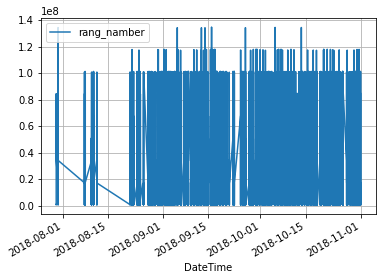

In [137]:
data.plot(grid=True)